In [1]:
import torch
from model.model_3D import *
from model.train_eval import *
import copy
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import h5py
from postprocessing.save_results import *
from postprocessing.plot_results import *
from postprocessing.metrics import single_roc_curve
from pathlib import Path
import pandas as pd
from matplotlib.patches import Patch




In [2]:
### check if cuda is available

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using {device}.")

Using cuda.


In [3]:
### import data

def load_with_hdf5(name):
    """
    Load tensor data from HDF5 with gzip compression
    """
    with h5py.File(f"data/{name}.h5", "r") as f:
        loaded_features = torch.from_numpy(f["features"][:])
        loaded_labels = torch.from_numpy(f["labels"][:])
    return TensorDataset(loaded_features, loaded_labels)

train_set = load_with_hdf5("train_set_ndvi_v2")
val_set = load_with_hdf5("val_set_ndvi_v2")
test_set = load_with_hdf5("test_set_ndvi_v2")


In [4]:
print(train_set.tensors[0].shape)
print(train_set.tensors[0][0].shape)


torch.Size([490, 2, 4, 1000, 500])
torch.Size([2, 4, 1000, 500])


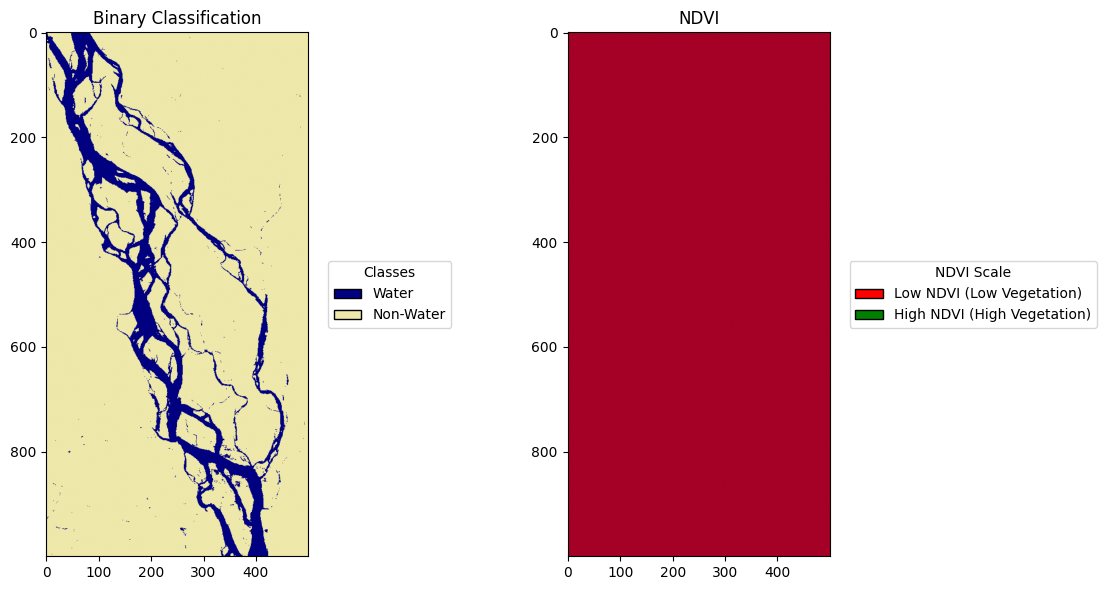

In [5]:
example_image_channel1 = val_set.tensors[0][10, 0, 0, :, :]
example_image_channel2 = val_set.tensors[0][10, 1, 0, :, :]

# Define the custom colormap for the binary classification
grey_cmap = ListedColormap(['palegoldenrod', 'navy'])

# Plot the example images
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Binary Classification Image
ax[0].imshow(example_image_channel1, cmap=grey_cmap)
ax[0].set_title('Binary Classification')

# Add a legend for Binary Classification outside the plot
legend_elements_1 = [
    Patch(facecolor='navy', edgecolor='black', label='Water'),
    Patch(facecolor='palegoldenrod', edgecolor='black', label='Non-Water')
]
ax[0].legend(
    handles=legend_elements_1,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),  # Place outside the right of the subplot
    title="Classes"
)

# NDVI Image
ax[1].imshow(example_image_channel2, cmap='RdYlGn')
ax[1].set_title('NDVI')

# Add a legend for NDVI outside the plot
legend_elements_2 = [
    Patch(facecolor='red', edgecolor='black', label='Low NDVI (Low Vegetation)'),
    Patch(facecolor='green', edgecolor='black', label='High NDVI (High Vegetation)')
]
ax[1].legend(
    handles=legend_elements_2,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),  # Place outside the right of the subplot
    title="NDVI Scale"
)

plt.tight_layout()
plt.subplots_adjust(right=0.8)  # Adjust space to make room for legends
plt.show()

In [7]:
# Convert the PyTorch tensors to NumPy arrays for processing
image1_np = example_image_channel1.numpy()  # Binary classification image
image2_np = example_image_channel2.numpy()  # NDVI image

# Optionally, create an overlay combining both images
overlay_np = (image1_np * 0.5) + (image2_np * 0.5)  # Example of overlay


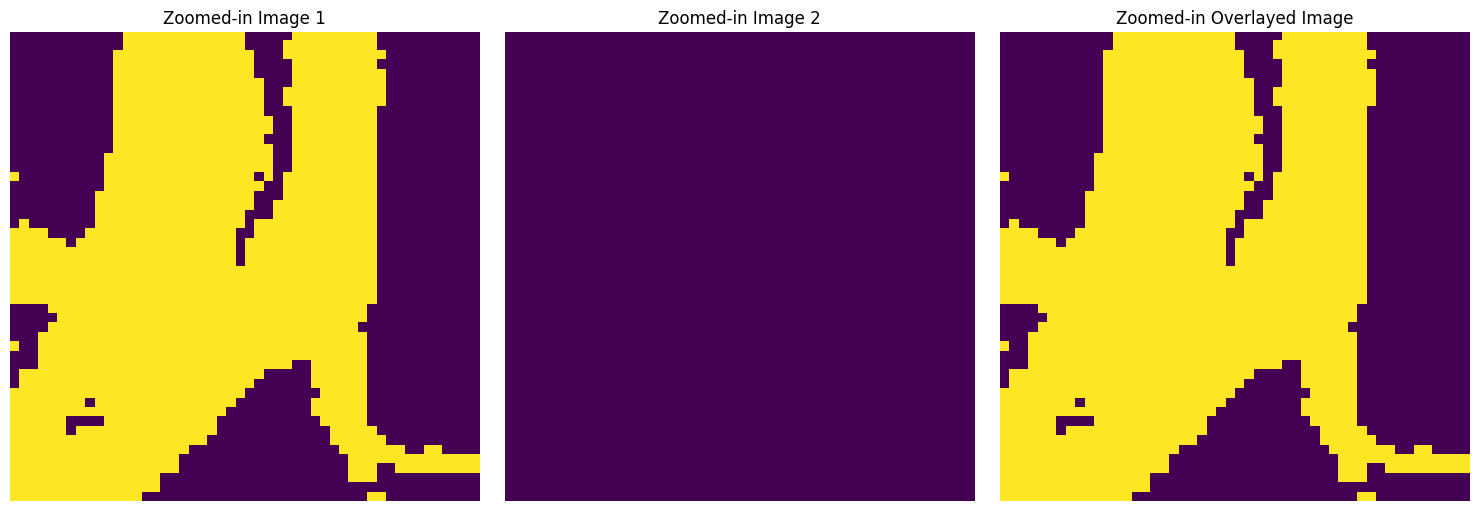

In [8]:
# Define the region of interest (zoom coordinates)
start_row, end_row = 50, 100  # Adjust as needed
start_col, end_col = 50, 100  # Adjust as needed

# Crop the zoomed region from all images
zoomed_image1 = image1_np[start_row:end_row, start_col:end_col]
zoomed_image2 = image2_np[start_row:end_row, start_col:end_col]
zoomed_overlay = overlay_np[start_row:end_row, start_col:end_col]

# Plot the zoomed-in regions for all three images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Zoomed-in Original Image 1
axs[0].imshow(zoomed_image1, cmap="viridis")
axs[0].set_title("Zoomed-in Image 1")
axs[0].axis("off")

# Zoomed-in Original Image 2
axs[1].imshow(zoomed_image2, cmap="viridis")
axs[1].set_title("Zoomed-in Image 2")
axs[1].axis("off")

# Zoomed-in Overlayed Image
axs[2].imshow(zoomed_overlay, cmap="viridis")
axs[2].set_title("Zoomed-in Overlayed Image")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:

# Define parameters used for saving the model

model_filename = f"models_machine/UNet3D_spatial_min loss_1_hid{init_hid_dim}_kernel3_max_lr{learning_rate}_step15_gamma0.75_bs{batch_size}_epochs10_wt0.5.pth"


n_channels = train_set[0][0].shape[0]
n_classes = 2 # ?
init_hid_dim = 8
kernel_size = 3
pooling = 'max'

#initialize model
model = UNet3D(n_channels=n_channels,
               n_classes=n_classes,
               init_hid_dim=init_hid_dim,
               kernel_size=kernel_size,
               pooling=pooling,
               bilinear=False,
               drop_channels=False)

# Load model state dictionary
model.load_state_dict(torch.load(model_filename))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Model loaded successfully!")


In [ ]:

# Load losses and metrics
losses_file = "metrics_and_losses/spatial_1_hid8_kernel3_max_lr0.05_step15_gamma0.75_bs16_epochs10_wt0.5_losses.csv"

df_losses = pd.read_csv(losses_file)
train_losses = df_losses["train_loss"].tolist()
val_losses = df_losses["val_loss"].tolist()

print("Losses loaded successfully!")

metrics_file = "metrics_and_losses/spatial_1_hid8_kernel3_max_lr0.05_step15_gamma0.75_bs16_epochs10_wt0.5_metrics.csv"

df_metrics = pd.read_csv(metrics_file)
accuracies = df_metrics["accuracy"].tolist()
precisions = df_metrics["precision"].tolist()
recalls = df_metrics["recall"].tolist()
f1_scores = df_metrics["f1_score"].tolist()
csi_scores = df_metrics["csi_score"].tolist()

metrics = [accuracies, precisions, recalls, f1_scores, csi_scores]
print("Metrics loaded successfully!")


In [ ]:

plot_losses_metrics(train_losses, val_losses, metrics, model, loss_f="BCE")



In [ ]:
sample_index = 5  # Example test sample index
show_evolution_nolegend_3d(sample_index, test_set, model)



